# Project : Tayara-Cars Prediction

## Import libraries

In [158]:
import math
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import cm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import tree   
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

import datetime
date = datetime.datetime.today()

## support functions

In [2]:
def plot_correlation_map(df):
    corr = df.corr()
    s , ax = plt.subplots(figsize=(12,10))
    cmap = sb.diverging_palette(220,10,as_cmap = True)
    s = sb.heatmap(corr,cmap = cmap,square=True,cbar_kws={ 'shrink' : .9 },ax=ax,
                   annot = True,annot_kws = { 'fontsize' : 12 })

In [3]:
def gouv_name(location):
    gouv = location.split(',')
    return gouv[0]

In [4]:
def price_rec(pr):
    ch = str(int(pr))
    if len(ch)<3:
        pr = pr*1000
    if len(ch)==3:
        pr = math.nan
    if (len(np.unique(list(ch)))==1):
        pr = math.nan
    return pr

In [5]:
def annee_rec(an):
    an = int(abs(an))
    if ((an < 22) & (an >= 0)):
        return int(an+2000)   
    elif ((an >= 80) & (an < 100)):
        return int(an+1900)
    elif ((an>=1970) & (an<=date.year)):
        return int(an)
    else:
        return math.nan
        

In [6]:
def km_rec(km):
    ch =''
    km = round(abs(km))
    ch = str(km)
    if (len(np.unique(list(str(km))))==1):
        return math.nan
    elif len(ch)>=7:
        res = int(ch[:6]) 
        return res
    elif ((len(ch)>=4) & (len(ch)<=6)):
        res = abs(km)
        return res
    elif ((len(ch) >= 1) & (len(ch)<=3)):
        res= abs(km)*1000    
        return res

In [7]:
def puissance_rec(ch):
    ch = int(ch)
    cv = []
    if (ch < 600) & (ch > 25): # convert ch (puissance) in cv (chevaux fiscaux)
        CO2=110 # mean CO2 value in [gr/km] 
        cv = round((CO2/45) + (0.736*ch/40)*1.6)
    if (ch>0) & (ch<26):
        cv = ch
    if (ch>=600) or (ch<=1):
        cv = math.nan
    return cv

## Import and explore data

In [8]:
path = 'C:\\Users\\omarb\\Documents\\Introduction to AI\\Jupyter\\Datasets\\'
df = pd.read_csv(path+"tayara_cars.csv",sep=',',skipinitialspace=True)
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10730 non-null  int64  
 1   location    10730 non-null  object 
 2   km          10723 non-null  float64
 3   annee       10728 non-null  object 
 4   marque      10728 non-null  object 
 5   model       10727 non-null  object 
 6   date        10730 non-null  object 
 7   price       10725 non-null  float64
 8   carburant   10727 non-null  object 
 9   puissance   10727 non-null  object 
 10  boite       10727 non-null  object 
 11  cylindre    10727 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1006.1+ KB


In [9]:
df

,Unnamed: 0,location,km,annee,marque,model,date,price,carburant,puissance,boite,cylindre
0,0,"Ben arous, Ezzahra",1.0,2021,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4,Jaune,Compacte
1,1,"Tunis, Tunis",180000.0,2008,Opel,Astra,14 mars 2021,21500.0,Diesel,1,Noir,Berline
2,2,"Ben arous, Ezzahra",1.0,2021,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4,Jaune,Compacte
3,3,"Tunis, Tunis",180000.0,2008,Opel,Astra,14 mars 2021,21500.0,Diesel,1,Noir,Berline
4,4,"Monastir, Autres villes",200000.0,1999,Renault,12,14 mars 2021,111111.0,Essence,4,Blanc,Autres
...,...,...,...,...,...,...,...,...,...,...,...,...
10725,10725,"Ben arous, Radès",86000.0,2013,Peugeot,208,6 février 2021,28800.0,Essence,5,Bleu,Compacte
10726,10726,"Gafsa, Redeyef",232000.0,2009,Renault,Megane,6 février 2021,23500.0,Essence,6,Noir,Berline
10727,10727,"Sfax, Sfax Médina",101000.0,2015,Kia,Rio,6 février 2021,37500.0,Essence,5,Noir,Berline
10728,10728,"Tataouine, Tataouine",273000.0,2008,Volkswagen,Passat,6 février 2021,29000.0,Essence,7,Noir,Autres


In [10]:
df.isnull().sum()

Unnamed: 0    0
location      0
km            7
annee         2
marque        2
model         3
date          0
price         5
carburant     3
puissance     3
boite         3
cylindre      3
dtype: int64

In [11]:
df = df.dropna(axis=0,how='any')

In [12]:
df.km.unique()[df.km.unique()<10]

array([ 1.00e+00,  0.00e+00,  2.00e+00,  8.00e+00,  3.00e+00,  5.00e+00,
       -1.00e+00,  7.00e+00,  4.00e+00, -1.88e+05, -3.74e+05, -1.30e+05,
        9.00e+00, -1.50e+02, -1.20e+02])

In [13]:
# Check if the price is not in dinar (thousands of dinar)
df.price.unique()[df.price.unique()<1000]

array([ 32.,  62.,  23., 500.,  34.,  26.,  39.,  15.,  25.,   6.,  52.,
        47.,  36.,  24.,  11.,  31.,  20.,  30.,  10., 123.,  37., 263.,
        49.,  35.,  64.,  21.,  13.,  29.,  27.,  22.,  19.,  45., 350.,
        50.,  33.,  17.,  53.,  69.,  88.,   9.,  65.,  60.,  80., 200.,
        55.,  12.,  16.,  40.,  87.,  46., 110., 120.,  38., 112., 400.,
       105., 777.,  71.,  18.,  59., 250.,  14., 220.,  61.,  66.,   7.,
       111., 109., 650.,  68.,  56.,   5.,  70.,  95., 950.,  44.,  41.,
        28.,  90., 163., 680., 850., 125., 300., 128., 450., 100.,  43.,
        42., 130., 165., 750., 470., 370., 700.,  58.,  99., 158., 170.,
       114.,  89., 320.,  63., 600., 800.,  82., 150.,  85.,  96., 520.,
       180., 260., 550.,  72.,  74.,  77.,  54., 160.,  83.,  57., 580.,
         8., 148., 155., 420., 222.,  67.,  78., 140.,  98., 108., 380.,
       118.,  48., 197., 185., 290., 900., 208.,  51., 126.,  75., 330.,
       135., 210., 360., 999., 138., 230.,  79., 22

Some price entries are in ten thousand dinars (ex: 25 -> 25000)
Others are misspelled (0 is extra or missing)

In [14]:
df.annee.unique()

array(['2021', '2008', '1999', '2019', '2013', '2009', '2000', '2012',
       '2010', '2004', '2016', '2002', '1997', '89', '2011', '2005',
       '5000', '2014', '1880', '1996', '2018', '1992', '1987', '2001',
       '2015', '2007', '112019', '2003', '2017', '1998', '2020', '216',
       '1984', '1994', '1991', '1985', '1986', '1993', '2222', '1995',
       '97', '2006', '25072018', '98984991', '1988', '1977', '10', '1990',
       '1982', '0', '207', '12222', '86', '1989', '9', '555', '88',
       '222222', '8', '1983', '1981', '66', '96', '2222222', '68', '123',
       '1', '11111', 'BMW', '211', '87', '13', '95', '1111', '98',
       '93835898', '111111', '1979', '1978', '93', '90', '92', '11',
       '1980', '213', '1900', '47', '9999', '20000', '1000', '99713043',
       '766', '200000', '19998', '7', '122006', '111', '5', '94', '20',
       '1950', '2', '101', '1960', '75000', '111112', '85', '1969', '25',
       '999', '12', '200', '95063694', '102019', '203', '199', '1111111',


*Annee* data is very messed, but we can use the data inside *date*, which seems clean.

clearly this date refers to when the offer was inserted in Tayara, not the date of acquisition of the car. Thus it is not a very important information

## Preprocess

In [15]:
#work on a copy of the original dataset
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10722 entries, 0 to 10729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10722 non-null  int64  
 1   location    10722 non-null  object 
 2   km          10722 non-null  float64
 3   annee       10722 non-null  object 
 4   marque      10722 non-null  object 
 5   model       10722 non-null  object 
 6   date        10722 non-null  object 
 7   price       10722 non-null  float64
 8   carburant   10722 non-null  object 
 9   puissance   10722 non-null  object 
 10  boite       10722 non-null  object 
 11  cylindre    10722 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1.1+ MB


In [16]:
# drop first unused column
data = data.drop('Unnamed: 0',axis=1)
# drop a wrong entry
data = data.drop(data[data['annee']=='BMW'].index,axis=0)
# rename color column
data.rename(columns={'boite':'couleur'},inplace=True)
data.couleur.unique()
# handle color 
dict_couleur={'Nouveau':math.nan,'Manuelle':math.nan,
       'Avec kilométrage':math.nan, 'Autre':math.nan, 'Berline':math.nan, '4 x 4':math.nan,
       'Automatique':math.nan,'Autres':math.nan,
       'Utilitaire':math.nan, 'Compacte':math.nan, 'Cabriolet':math.nan, 'Monospace':math.nan, 'RS':math.nan,
        'Pick up':math.nan, 'Pièces manquantes':math.nan}
data.couleur=data['couleur'].replace(dict_couleur) 
data.couleur.fillna(data.couleur.mode()[0],inplace=True)

In [17]:
# extract city name and drop location
data.location=data['location'].map(gouv_name,na_action='ignore')
data.location.fillna(data.location.mode()[0],inplace=True)

[Text(0.5, 0, 'puissance in CH'), Text(0.5, 1.0, 'boxplot')]

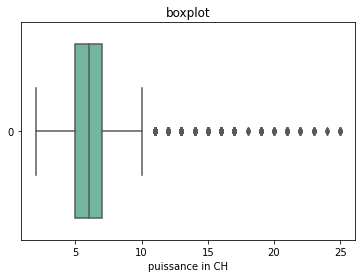

In [18]:
# Handle horse power data

data.puissance=pd.to_numeric(data.puissance,errors='coerce')
data.dropna(axis=0, how='any', thresh=None, subset=['puissance'], inplace=True)
data.puissance=data['puissance'].map(puissance_rec,na_action='ignore')
data.dropna(axis=0, how='any', thresh=None, subset=['puissance'], inplace=True)
data['puissance']=data['puissance'].astype(int)
# plot horse power data
ax = sb.boxplot(data=data['puissance'],orient='h',palette='Set2')
ax.set(xlabel='puissance in CH',title='boxplot')

In [19]:
data.puissance.describe()

count    10131.000000
mean         6.270358
std          2.489990
min          2.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         25.000000
Name: puissance, dtype: float64

[Text(0.5, 0, 'annee'), Text(0.5, 1.0, 'boxplot')]

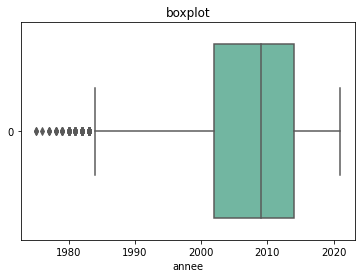

In [20]:
# Handle year data
data['annee']=data['annee'].astype(int)
data['annee']=data['annee'].map(annee_rec,na_action='ignore')
data.fillna(round(data['annee'].mean()), inplace=True)

ax = sb.boxplot(data=data['annee'],orient='h',palette='Set2')
ax.set(xlabel='annee',title='boxplot')

[Text(0.5, 0, 'price'), Text(0.5, 1.0, 'boxplot')]

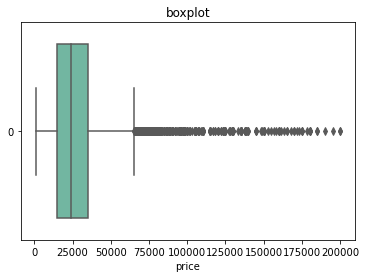

In [21]:
# Handle price 
data.price=data['price'].map(price_rec)
data.dropna(axis=0, how='any', thresh=None, subset=['price'], inplace=True)

ax = sb.boxplot(data=data['price'],orient='h',palette='Set2')
ax.set(xlabel='price',title='boxplot')

C:\Users\omarb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'km'), Text(0.5, 1.0, 'boxplot')]

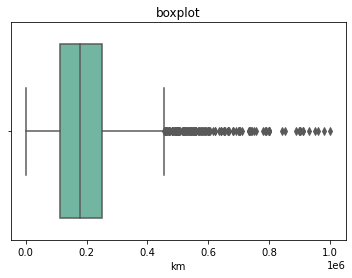

In [22]:
# Handle km 
data['km']=data['km'].map(km_rec,na_action='ignore')
data.dropna(axis=0, how='any', thresh=None, subset=['km'], inplace=True)
ax = sb.boxplot(data['km'],palette='Set2')
ax.set(xlabel='km',title='boxplot')

In [23]:
data.isnull().sum()

location     0
km           0
annee        0
marque       0
model        0
date         0
price        0
carburant    0
puissance    0
couleur      0
cylindre     0
dtype: int64

In [24]:
# take logical km values
mask= ((data.km >= 600000) & (data.km<=0))
data.drop(data[mask].index, inplace=True)

# take price values under 200k
mask =((data.price >= 200000) & (data.price<=1000))
data.drop(data[mask].index,inplace=True)

In [25]:
newCols = {'km':'km','annee':'year','marque':'brand','carburant':'Fuel_Type','couleur':'Color','puissance':'Horse_pow','cylindre':'type'}
data.rename(columns=newCols, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8827 entries, 5 to 10729
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   8827 non-null   object 
 1   km         8827 non-null   float64
 2   year       8827 non-null   float64
 3   brand      8827 non-null   object 
 4   model      8827 non-null   object 
 5   date       8827 non-null   object 
 6   price      8827 non-null   float64
 7   Fuel_Type  8827 non-null   object 
 8   Horse_pow  8827 non-null   int32  
 9   Color      8827 non-null   object 
 10  type       8827 non-null   object 
dtypes: float64(3), int32(1), object(7)
memory usage: 1.1+ MB


In [26]:
# replace years with number of years
data['year']=data['year'].astype(int)
data['Current Year']=2021
data['nb_year']=data['Current Year']- data['year']
data=data.drop(['Current Year'],axis=1)

In [27]:
data[data.brand=='Volkswagen'].price.describe()

count      1298.000000
mean      29980.961479
std       18749.356307
min        1000.000000
25%       16500.000000
50%       26500.000000
75%       39375.000000
max      200000.000000
Name: price, dtype: float64

In [28]:
# location encoding
locations = data.location.unique()
code = list(range(1,len(locations)+1))
loc_dict = dict(zip(locations,code))
loc_dict = {'location':loc_dict}
data.replace(loc_dict,inplace=True)
data
print(loc_dict)

{'location': {'Tunis': 1, 'Sfax': 2, 'Nabeul': 3, 'Sousse': 4, 'Ariana': 5, 'Zaghouan': 6, 'Ben arous': 7, 'Bizerte': 8, 'Siliana': 9, 'Le kef': 10, 'Tataouine': 11, 'Jendouba': 12, 'Médenine': 13, 'Béja': 14, 'Monastir': 15, 'La manouba': 16, 'Gabès': 17, 'Kébili': 18, 'Sidi bouzid': 19, 'Mahdia': 20, 'Kairouan': 21, 'Gafsa': 22, 'Tozeur': 23, 'Kasserine': 24}}


In [29]:
# Brand encoding
brands = data.brand.unique()
code = list(range(1,len(brands)+1))
brand_dict = dict(zip(brands,code))
brand_dict = {'brand':brand_dict}
data.replace(brand_dict,inplace=True)
data
print(brand_dict)

{'brand': {'Volkswagen': 1, 'Peugeot': 2, 'BMW': 3, 'Isuzu': 4, 'Nissan': 5, 'Citroen': 6, 'Mercedes-Benz': 7, 'Fiat': 8, 'Ford': 9, 'Mazda': 10, 'Hyundai': 11, 'Renault': 12, 'Audi': 13, 'Seat': 14, 'Mitsubishi': 15, 'Chevrolet': 16, 'Chery': 17, 'Kia': 18, 'Opel': 19, 'Toyota': 20, 'Suzuki': 21, 'Ssangyong': 22, 'Iveco': 23, 'Autres': 24, 'Acrea': 25, 'Skoda': 26, 'AC': 27, 'Jeep': 28, 'Smart': 29, 'Dacia': 30, 'Land Rover': 31, 'Mahindra': 32, 'Porsche': 33, 'Daihatsu': 34, 'mini': 35, 'Honda': 36, 'Alfa Romeo': 37, 'Daewoo': 38, 'Volvo': 39, 'Jaguar': 40, 'Aston Martin': 41, 'Dodge': 42, 'Changhe': 43, 'Cadillac': 44, 'Geely': 45, 'Man': 46, 'UFO': 47, 'lancia': 48, 'Infiniti': 49, 'Chrysler': 50, 'Subaru': 51, 'Rover': 52, 'Foton': 53, 'BYD': 54, 'Bentley': 55, 'Maserati': 56, 'Hummer': 57}}


In [30]:
# Fuel_type encoding
Fuel_Types = data.Fuel_Type.unique()
code = list(range(1,len(Fuel_Types)+1))
Fuel_Type_dict = dict(zip(Fuel_Types,code))
Fuel_Type_dict = {'Fuel_Type':Fuel_Type_dict}
data.replace(Fuel_Type_dict,inplace=True)
data
print(Fuel_Type_dict)

{'Fuel_Type': {'Essence': 1, 'Diesel': 2, 'Hybride': 3, 'Electrique': 4}}


In [31]:
# handle type column
## get indexes of non numeric data
a = pd.to_numeric(data['type'],errors='coerce')
not_type=a[a.isnull()==True].index.tolist()

data=data.loc[not_type]
## filter out 
mask =((data.type=='&gt;4.0') | (data.type=='&lt;1.0'))
data.drop(data[mask].index,inplace=True)

data.type.unique()

array(['Manuelle', 'Compacte', 'Berline', 'Autres', '4 x 4',
       'Avec kilométrage', 'Utilitaire', 'Monospace', 'Cabriolet',
       'Nouveau', 'Pick up', 'Automatique', 'Pièces manquantes', 'RS',
       'Non dédouanné'], dtype=object)

In [32]:
data

,location,km,year,brand,model,date,price,Fuel_Type,Horse_pow,Color,type,nb_year
5,1,29000.0,2019,1,Polo,14 mars 2021,45000.0,1,5,Blanc,Manuelle,2
6,1,122000.0,2013,2,208,13 mars 2021,26800.0,1,5,Marron,Compacte,8
7,2,251000.0,2009,3,Serie 1,13 mars 2021,32000.0,1,7,Noir,Berline,12
8,3,300000.0,2013,4,D-MAX,13 mars 2021,62000.0,2,8,Gris,Autres,8
9,2,315000.0,2000,2,406,13 mars 2021,17000.0,1,7,Gris,Berline,21
...,...,...,...,...,...,...,...,...,...,...,...,...
10725,7,86000.0,2013,2,208,6 février 2021,28800.0,1,5,Bleu,Compacte,8
10726,22,232000.0,2009,12,Megane,6 février 2021,23500.0,1,6,Noir,Berline,12
10727,2,101000.0,2015,18,Rio,6 février 2021,37500.0,1,5,Noir,Berline,6
10728,11,273000.0,2008,1,Passat,6 février 2021,29000.0,1,7,Noir,Autres,13


In [33]:
types = data.type.unique()
code = list(range(1,len(types)+1))
type_dict = dict(zip(types,code))
type_dict = {'type':type_dict}
data.replace(type_dict,inplace=True)
print(type_dict)

{'type': {'Manuelle': 1, 'Compacte': 2, 'Berline': 3, 'Autres': 4, '4 x 4': 5, 'Avec kilométrage': 6, 'Utilitaire': 7, 'Monospace': 8, 'Cabriolet': 9, 'Nouveau': 10, 'Pick up': 11, 'Automatique': 12, 'Pièces manquantes': 13, 'RS': 14, 'Non dédouanné': 15}}


In [34]:
data.describe()

,location,km,year,brand,price,Fuel_Type,Horse_pow,type,nb_year
count,8270.000000,8270.000000,8270.000000,8270.000000,8270.000000,8270.000000,8270.000000,8270.000000,8270.000000
mean,6.429141,189488.683676,2008.256711,9.229141,29700.037001,1.355865,6.212455,3.811004,12.743289
std,6.344296,113957.148772,8.061755,7.970868,21668.175654,0.486073,2.361145,2.173889,8.061755
min,1.000000,1000.000000,1976.000000,1.000000,1000.000000,1.000000,2.000000,1.000000,0.000000
25%,1.000000,113000.000000,2004.000000,2.000000,16000.000000,1.000000,5.000000,2.000000,6.000000
50%,4.000000,180000.000000,2010.000000,8.000000,25000.000000,1.000000,5.000000,3.000000,11.000000
75%,8.000000,250000.000000,2015.000000,12.000000,36000.000000,2.000000,7.000000,4.000000,17.000000
max,24.000000,999900.000000,2021.000000,56.000000,200000.000000,4.000000,25.000000,15.000000,45.000000


## Visualization

In [35]:
ex = data[data['type']=='4 x 4']

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8270 entries, 5 to 10729
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   8270 non-null   int64  
 1   km         8270 non-null   float64
 2   year       8270 non-null   int32  
 3   brand      8270 non-null   int64  
 4   model      8270 non-null   object 
 5   date       8270 non-null   object 
 6   price      8270 non-null   float64
 7   Fuel_Type  8270 non-null   int64  
 8   Horse_pow  8270 non-null   int32  
 9   Color      8270 non-null   object 
 10  type       8270 non-null   int64  
 11  nb_year    8270 non-null   int64  
dtypes: float64(2), int32(2), int64(5), object(3)
memory usage: 775.3+ KB


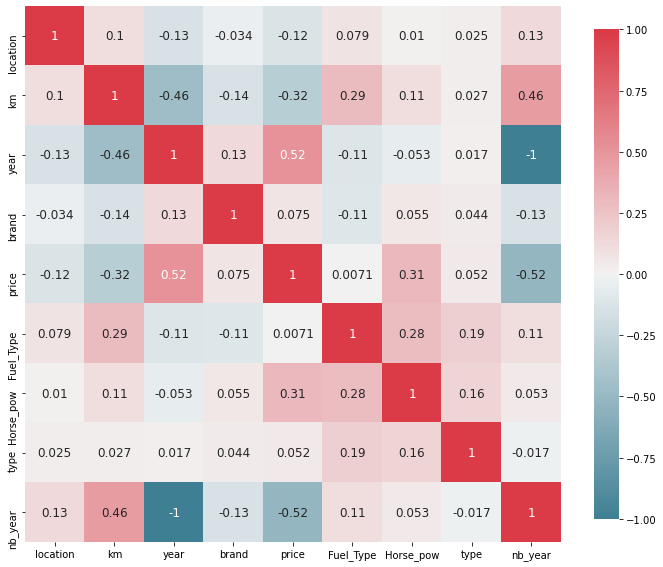

In [113]:
num_columns=[c for c in data.columns if data[c].dtype !='object']

plot_correlation_map(data[num_columns])

In [103]:
#sb.pairplot(data,x_vars=num_feat,y_vars='price')

Text(0, 0.5, 'count')

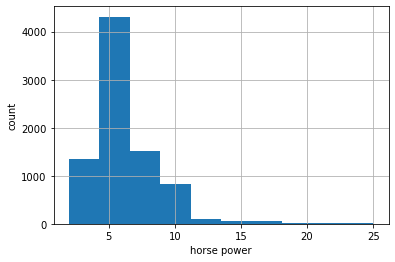

In [39]:
data.Horse_pow.hist()
plt.xlabel('horse power')
plt.ylabel('count')

Text(0, 0.5, 'count')

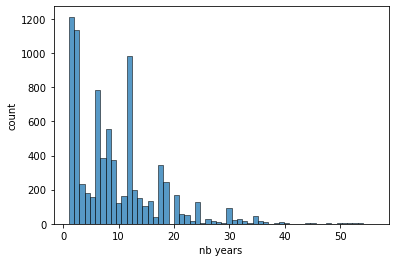

In [40]:
sb.histplot(data.brand,bins=58)
plt.xlabel('nb years')
plt.ylabel('count')


In [41]:
target = data.price


In [115]:
# numeric features
num_feat = data[num_columns].drop('price',axis=1)


# Regression Model

## Linear

In [154]:
#feature selection
x = num_feat['nb_year'].values.reshape(-1, 1)
y = target.values
# Split data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=40) 
# Model and degree selection
lg=LinearRegression()
# train model
lg.fit(x_train, y_train)
predicted = lg.predict(x_test)
# prediction error and fit#
MAE = mean_absolute_error(y_test, predicted)
R2_lg = metrics.r2_score(y_test,predicted)
print("MAE: ", MAE)
print("R squared: ",R2_lg )
print("Coefficients: ", lg.coef_)
print("b: ",lg.intercept_)
print("RSR-ratio: ", RMSE/data['price'].std(axis=0)) # RSR = RMSE/StandardDev(Price) 
                                                           #the lower the better our model is

MAE:  11861.204423865154
R squared:  0.2850645755057196
Coefficients:  [-1397.13687305]
b:  47457.37137179237
RSR-ratio:  0.5927441467524566


## Multi-linear

In [155]:
x = num_feat.values
y = target.values

x_train,x_test,y_train,y_test = train_test_split(num_feat,target,test_size=0.15,random_state=30) 
# Model and degree selection
multi_lg=LinearRegression()
# train model
multi_lg.fit(x_train, y_train)
predicted = multi_lg.predict(x_test)
# prediction error and fit
MAE = mean_absolute_error(y_test, predicted)
R2_multi_lg= metrics.r2_score(y_test,predicted)
inc = (R2_multi_lg-R2_lg)/R2_lg *100
print("MAE: ", MAE)
print("R squared: ",R2_multi_lg)
print("Accuracy increase: %5.2f"%(inc),'%')
print("Coefficients: ", multi_lg.coef_)
print("b: ",multi_lg.intercept_)
print("RSR-ratio: ", RMSE/data['price'].std(axis=0)) # RSR = RMSE/StandardDev(Price) 
                                                           #the lower the better our model is

MAE:  9158.611735954133
R squared:  0.5023452344268726
Accuracy increase: 76.22 %
Coefficients:  [-1.87007108e+02 -2.71301393e-02  6.32246571e+02 -8.43890408e+01
  1.54684319e+02  3.22114465e+03 -1.09984784e+02 -6.32246571e+02]
b:  -1244612.8424633841
RSR-ratio:  0.5927441467524566


## Polynomial Regression

In [156]:
x = num_feat.values
y = target.values
# Split data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=30) 
# Model and degree selection
pg=LinearRegression()
poly = PolynomialFeatures(degree=2)
# transform train and test input data
x_train_fit = poly.fit_transform(x_train) 
x_test_fit = poly.transform(x_test)
# train model
pg.fit(x_train_fit, y_train)
predicted = pg.predict(x_test_fit)
# prediction error and fit
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predicted))
R2_pg= metrics.r2_score(y_test,predicted)
inc = (R2_pg-R2_multi_lg)/R2_multi_lg *100

print("MAE: ", mean_absolute_error(y_test, predicted))
print("R squared: ",R2_pg)
print("Accuracy increase: %5.2f"%(inc),'%')
print("Coefficients: ", pg.coef_)
print("b: ",pg.intercept_)
print("RSR-ratio: ", RMSE/data['price'].std(axis=0)) # RSR = RMSE/StandardDev(Price) 
                                                    #the lower the better our model is
mean_absolute_error

MAE:  8129.2185513617305
R squared:  0.5750969256568619
Accuracy increase: 14.48 %
Coefficients:  [ 7.10543494e-04  6.30062718e-03  3.09136959e-06 -7.51642032e-03
  6.28624681e-03  6.17413092e-02 -1.13197768e-01  1.33181285e-02
  7.51642425e-03 -2.80361253e+00  2.00873593e-05  6.64141393e-02
 -6.64500661e+00  5.62516269e+01 -7.13811396e+01  2.89019456e+00
  1.35888803e+01  3.03504762e-08 -3.06994392e-05  7.80006102e-04
  1.54335612e-04 -2.19158478e-03  1.00396804e-03  1.71491374e-03
 -4.78606911e+00 -4.29855162e-01  6.96727128e+00  5.17252773e+00
  3.07101500e-01 -1.04046204e+01  7.14726145e+00  1.23889722e+01
  2.41674896e+01  2.24250459e+01  1.31343817e+01 -2.50946348e+03
 -6.64580014e+02 -9.66491755e+02  1.17811911e+02 -1.48738203e+02
  1.18705946e+02 -2.33945210e+02 -8.54642825e+01  2.66088396e+01
  2.55953100e+01]
b:  19553407.914179448
RSR-ratio:  0.5927441467524566


<function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>

In [46]:
print(brand_dict)

{'brand': {'Volkswagen': 1, 'Peugeot': 2, 'BMW': 3, 'Isuzu': 4, 'Nissan': 5, 'Citroen': 6, 'Mercedes-Benz': 7, 'Fiat': 8, 'Ford': 9, 'Mazda': 10, 'Hyundai': 11, 'Renault': 12, 'Audi': 13, 'Seat': 14, 'Mitsubishi': 15, 'Chevrolet': 16, 'Chery': 17, 'Kia': 18, 'Opel': 19, 'Toyota': 20, 'Suzuki': 21, 'Ssangyong': 22, 'Iveco': 23, 'Autres': 24, 'Acrea': 25, 'Skoda': 26, 'AC': 27, 'Jeep': 28, 'Smart': 29, 'Dacia': 30, 'Land Rover': 31, 'Mahindra': 32, 'Porsche': 33, 'Daihatsu': 34, 'mini': 35, 'Honda': 36, 'Alfa Romeo': 37, 'Daewoo': 38, 'Volvo': 39, 'Jaguar': 40, 'Aston Martin': 41, 'Dodge': 42, 'Changhe': 43, 'Cadillac': 44, 'Geely': 45, 'Man': 46, 'UFO': 47, 'lancia': 48, 'Infiniti': 49, 'Chrysler': 50, 'Subaru': 51, 'Rover': 52, 'Foton': 53, 'BYD': 54, 'Bentley': 55, 'Maserati': 56, 'Hummer': 57}}


In [47]:
print(type_dict)

{'type': {'Manuelle': 1, 'Compacte': 2, 'Berline': 3, 'Autres': 4, '4 x 4': 5, 'Avec kilométrage': 6, 'Utilitaire': 7, 'Monospace': 8, 'Cabriolet': 9, 'Nouveau': 10, 'Pick up': 11, 'Automatique': 12, 'Pièces manquantes': 13, 'RS': 14, 'Non dédouanné': 15}}


In [141]:
x_pred = data[(data['brand']==2) 
               & (data['km'] <150000)
               & (data['type']==2 )
               & (data['Fuel_Type']==1 )
             ]
x_pred=x_pred.iloc[3]
print(x_pred)
real_price = x_pred.price
x_pred=x_pred[num_columns].drop('price').values.reshape(1, -1)
x_pred = poly.fit_transform(x_pred)
price_pred = pg.predict(x_pred)
print('prediction: ',price_pred)
print('tayara price: ',real_price)

location                1
km                  80000
year                 2014
brand                   2
model                 308
date         13 mars 2021
price               37000
Fuel_Type               1
Horse_pow               5
Color                Gris
type                    2
nb_year                 7
Name: 221, dtype: object
prediction:  [38841.17040818]
tayara price:  37000.0


# Random Forest Regressor

In [49]:
x = num_feat.values
y = target.values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=30) 

In [159]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [50]:
len(y_train)

6202

In [160]:
# loop over max_depth to calculate best tree depth
score = 100000
best_depth = 0
for i in range(1,20):
    DecTree = tree.DecisionTreeRegressor(max_depth=i,criterion='mse')
    DecTree.fit(x_train,y_train)
    y_pred =  DecTree.predict(x_test)
    acc = metrics.mean_absolute_error(y_test, y_pred)
    print('tree depth:{} '.format(i)+"score:{}".format(acc))
    if acc<score:
        score = acc
        best_depth = i
print(best_depth,score)

tree depth:1 score:11063.086474527112
tree depth:2 score:9721.304670290405
tree depth:3 score:9035.312634278695
tree depth:4 score:8365.006412004708
tree depth:5 score:7957.171308109193
tree depth:6 score:7645.725620957639
tree depth:7 score:7547.604223203256
tree depth:8 score:7595.950260966692
tree depth:9 score:7680.2878079809425
tree depth:10 score:7868.267680044815
tree depth:11 score:7801.581862693457
tree depth:12 score:7737.640272227509
tree depth:13 score:7933.717188273125
tree depth:14 score:7891.771274186368
tree depth:15 score:8037.038500711994
tree depth:16 score:8115.502843955518
tree depth:17 score:8117.270487546877
tree depth:18 score:8248.909205843898
tree depth:19 score:8355.55429495006
7 7547.604223203256


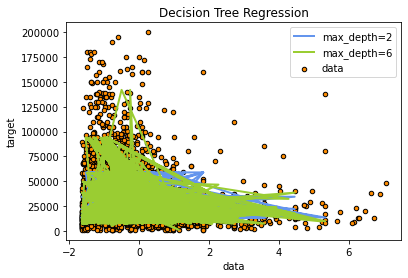

In [161]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=7)
regr_1.fit(x_train,y_train)
regr_2.fit(x_train,y_train)

# Predict

y_1 = regr_1.predict(x_test)
y_2 = regr_2.predict(x_test)

# Plot the results
plt.figure()
plt.scatter(x_train[:,1],y_train, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(x_test[:,1], y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(x_test[:,1], y_2, color="yellowgreen", label="max_depth=6", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [162]:
# loop over n_estimators to calculate best one
score = 10000
best_n = 1
for i in range(50,400,50):
    RanFo = RandomForestRegressor(n_estimators=i,max_depth=best_depth,criterion='mse')
    RanFo.fit(x_train,y_train)
    y_pred = RanFo.predict(x_test)
    acc = metrics.mean_absolute_error(y_test, y_pred)
    print('n:{} '.format(i)+"score:{}".format(acc))
    if acc<score:
        score = acc
        best_n = i
print(score,best_n)

n:50 score:6959.298894057202
n:100 score:6968.331946881132
n:150 score:6962.578410091314
n:200 score:6951.381679549301
n:250 score:6983.959499834103
n:300 score:6936.775967473132
n:350 score:6934.783480813773
6934.783480813773 350


In [163]:
RanFo = RandomForestRegressor(n_estimators=best_n,max_depth=best_depth)
RanFo.fit(x_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=350)

In [164]:
y_pred = RanFo.predict(x_test)
print("score:{}".format(metrics.mean_absolute_error(y_test, y_pred)))

score:6959.886392173785


In [166]:
x_pred = data[(data['brand']==2) 
               & (data['km'] <150000)
               & (data['type']==2 )
               & (data['Fuel_Type']==1 )
             ]
x_pred=x_pred.iloc[3]

print(x_pred)
real_price = x_pred.price
x_pred=x_pred[num_columns].drop('price').values.reshape(1, -1)
price_pred = RanFo.predict(scaler.transform(x_pred))
print('prediction: ',price_pred)
print('tayara price: ',real_price)

location                1
km                  80000
year                 2014
brand                   2
model                 308
date         13 mars 2021
price               37000
Fuel_Type               1
Horse_pow               5
Color                Gris
type                    2
nb_year                 7
Name: 221, dtype: object
prediction:  [31984.00711572]
tayara price:  37000.0


In [167]:
scores = -1*cross_val_score(RanFo, x, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

In [168]:
scores

array([8763.3966901 , 7775.02109209, 7736.43001223, 7843.71992785,
       7997.34363417])

In [144]:
scores = -1*cross_val_score(pg, x, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

In [145]:
scores

array([11038.14848016, 10076.08785033,  9654.30414899, 10252.26561384,
       10156.89021495])